# Лабораторная работа №6
## ПРИМЕНЕНИЕ ВЕЙВЛЕТ МЕТОДОВ ДЛЯ АНАЛИЗА ВРЕМЕННЫХ РЯДОВ
### Котов Иван Юрьевич
### Вариант: 14
### Группа: РИМ-181226

Сначала импортируйте в свой код нужные библиотеки, функции и т.д

In [310]:
import numpy as np
import numpy.random as rand
import matplotlib.pyplot as plt
import h5py
import pywt
%matplotlib inline

Создадим зашумленный временной ряд с 2 периодиками:

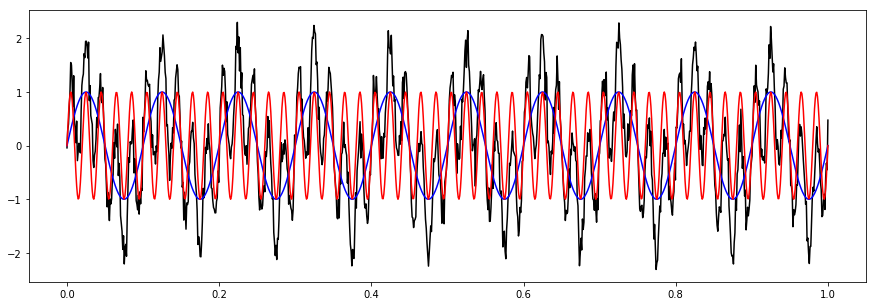

In [311]:
t = np.linspace(0, 1, 1024)
f1 = 10
f2 = 50

F = np.sin(2*np.pi*f1*t) + np.sin(2*np.pi*f2*t)\
    +0.2*rand.randn(len(t))

plt.figure(figsize = (15, 5))
plt.plot(t, F, 'k')
plt.plot(t, np.sin(2*np.pi*f1*t), 'b')
plt.plot(t, np.sin(2*np.pi*f2*t), 'r')
plt.show()

Наиболее широкой библиотекой для работы с вейвлетами в Python
является PyWavelets. При работе с вейвлетами надо понимать, что это
очень гибкий инструмент со множеством параметров. Во-первых,
самым главным параметр вейвлет-разложения является сам
материнский (базисный) вейвлет. Множество доступных в
библиотеке PyWavelets семейств вейвлетов и их модификаций
доступно на сайте: http://wavelets.pybytes.com. Внимательно изучите
эти семейства, так как выбор базового вейвлета существенно влияет
на конечный результат декомпозиции по принципу самоподобия
выделенных компонент и выбранного вейвлета.

Для начала используем вейвлет Мейера:

In [312]:
wvlt_dmey = pywt.Wavelet('dmey')

In [313]:
print(wvlt_dmey)

Wavelet dmey
  Family name:    Discrete Meyer (FIR Approximation)
  Short name:     dmey
  Filters length: 62
  Orthogonal:     True
  Biorthogonal:   True
  Symmetry:       symmetric
  DWT:            True
  CWT:            False


Во-вторых, декомпозиция с помощью дискретных вейвлетов
происходит до определенного уровня (level), ограниченного размером
доступных данных. В нашем случае возможно разложение до 4
уровня:

In [314]:
pywt.dwt_max_level(len(F), wvlt_dmey)

4

В-третьих, по краям временного интервала вейвлет может по-разному
трактовать конструируемые точки для экстраполяции (mode):
простое дополнение нулями, константами,
симметрично/асимметрично, периодически и т.д. В зависимости от
вида исходных данных, лучше подходит тот или иной режим.

Ну и наконец, декомпозиция всегда происходит в виде комбинации
коэффициентов Аппроксимации (cA) плюс Детали (cD). Всегда есть
одна аппроксимация, а число деталей равно уровню декомпозиции.
Меняя выбор группировки коэффициентов аппроксимации и деталей,
будут меняться восстановленные компоненты и соответствующая
декомпозиция ряда.

Разобьем наш исходный ряд на компоненты с помощью вейвлета
Мейера, в режиме периодизации, до 4 уровня декомпозиции:

In [315]:
cA4, cD4, cD3, cD2, cD1 = pywt.wavedec(F, wvlt_dmey, mode='periodization', level=4)

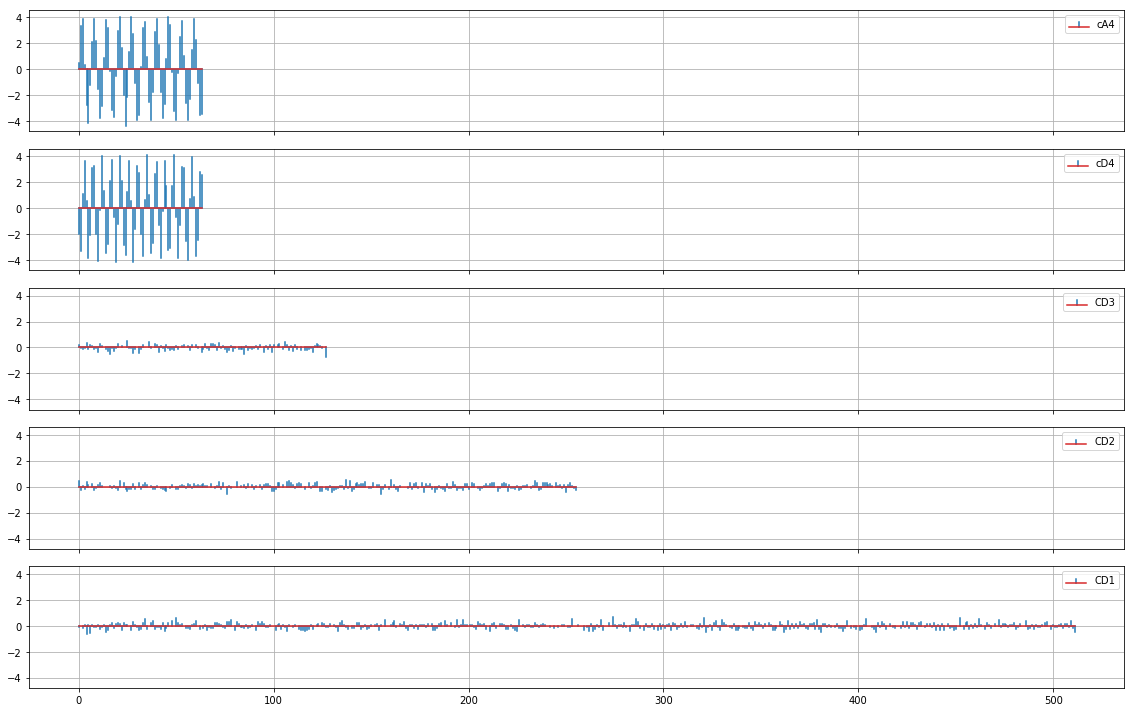

In [316]:
fig, ax = plt.subplots(5, 1, figsize=(16, 10), sharex = True, sharey=True)

for i,l,labl in [[0,cA4,'cA4'],
                  [1,cD4,'cD4'],
                  [2,cD3,'CD3'],
                  [3,cD2,'CD2'],
                  [4,cD1,'CD1']]:
    ax[i].stem(l, label = labl, markerfmt=' ')
    ax[i].grid()
    ax[i].legend()
    
plt.tight_layout()    
plt.show()

Обратите внимание, как выглядят выходные результаты: одна
аппроксимация cA4 с номером уровня и 4 детали с убывающими
номерами от 4 уровня cD4 до 1 уровня cD1. Если бы мы
декомпозировали ряд на 3 уровня (level=3), то тогда выходные
значения следовало бы записать как: cA3, cD3, cD2, cD1. Можно на
выходе функции использовать и одну переменную, но ее все равно
придется разбивать на отдельные элементы. Также следует помнить,
что в результате декомпозиции получаются не новые временные
ряды, а только вейвлет-коэффициенты декомпозиции.

In [317]:
def polt_grid_legend(ax,l):
    
    for i in range(l):
        ax[i].grid()
        ax[i].legend()

In [318]:
def plot_f(F,Fre1,Fre2,label1,label2):
    fig, ax = plt.subplots(3, 1, figsize=(16, 10), sharex = True, sharey=True)

    ax[0].plot(t, F, alpha = 0.5, label = 'F')
    ax[0].plot(t, Fre1, label = label1)
    ax[0].plot(t, Fre2, label = label2)

    ax[1].plot(t, np.sin(2*np.pi*f1*t), label = 'f1')
    ax[1].plot(t, Fre1, label = label1)

    ax[2].plot(t, np.sin(2*np.pi*f2*t), label = 'f2')
    ax[2].plot(t, Fre2, label = label2)

    polt_grid_legend(ax,3)

    plt.tight_layout()
    plt.show()

Восстановим две периодики исходного модельного ряда:

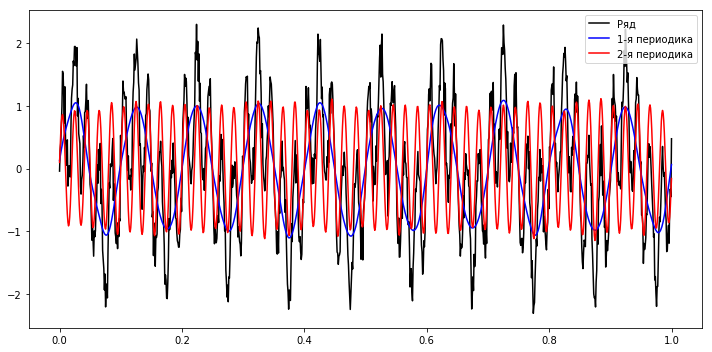

In [319]:
Fre1 = pywt.waverec((cA4, None, None, None, None), wvlt_dmey, mode='periodization')
Fre2 = pywt.waverec((None, cD4, None, None, None), wvlt_dmey, mode='periodization')
plt.figure(figsize = (10, 5))
plt.plot(t, F, 'k',label = 'Ряд')
plt.plot(t, Fre1, 'b',label = '1-я периодика') # это будет первая периодика
plt.plot(t, Fre2, 'r',label = '2-я периодика') # это будет вторая периодика
plt.legend()
plt.tight_layout()
plt.show()

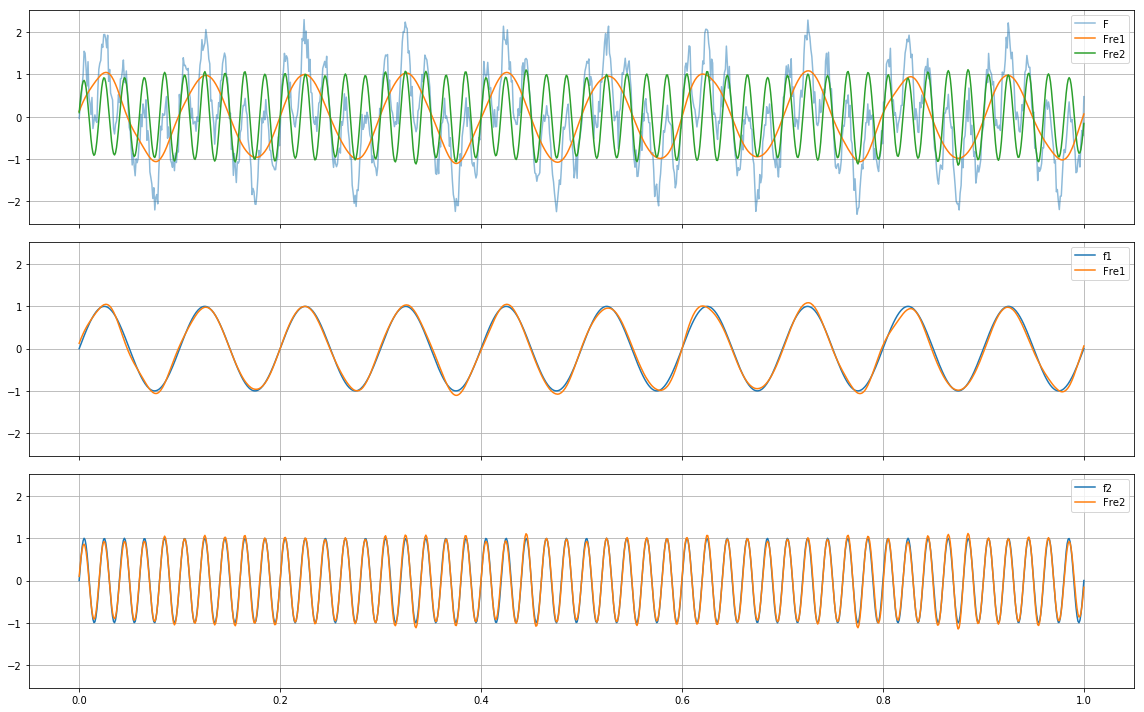

In [320]:
plot_f(F,Fre1,Fre2,'Fre1','Fre2')

Снова обратите внимание на форму записи восстанавливаемых
компонент. Те коэффициенты, которые мы не хотим использовать
для реконструкции компонент (лишние детали и т.д.), мы заменяем
на None. Меняя комбинации используемых и неиспользуемых
аппроксимаций и деталей, мы будем получать разные
восстановленные компоненты.

Проведите аналогичную декомпозицию для 3 уровня (level = 3). Вейвлет не меняйте. Сравните полученные результаты.

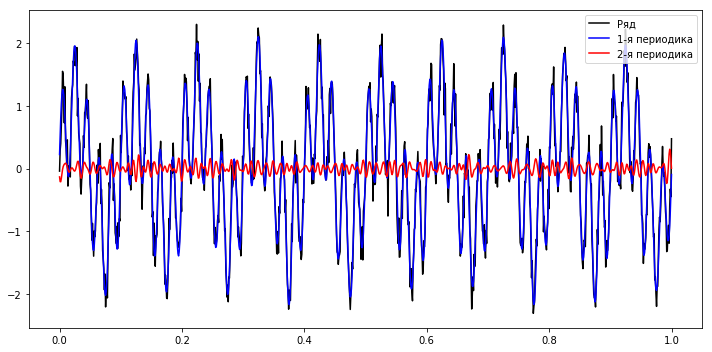

In [321]:
cA3, cD3, cD2, cD1 = pywt.wavedec(F, wvlt_dmey, mode='periodization', level=3)
Fre1 = pywt.waverec((cA3, None, None, None), wvlt_dmey, mode='periodization')
Fre2 = pywt.waverec((None, cD3, None, None), wvlt_dmey, mode='periodization')
plt.figure(figsize = (10, 5))
plt.plot(t, F, 'k',label = 'Ряд')
plt.plot(t, Fre1, 'b',label = '1-я периодика') # это будет первая периодика
plt.plot(t, Fre2, 'r',label = '2-я периодика') # это будет вторая периодика
plt.legend()
plt.tight_layout()
plt.show()

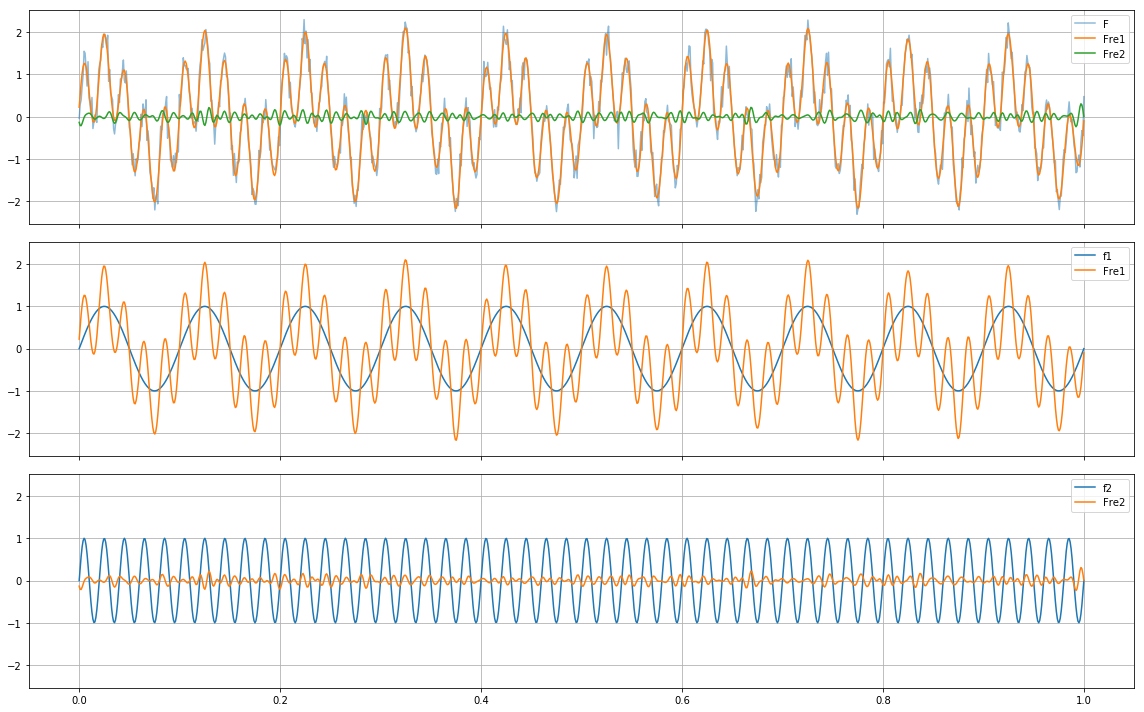

In [322]:
plot_f(F,Fre1,Fre2,'Fre1','Fre2')

Повторите все проделанные шаги по декомпозиции ряда и
восстановлению его компонент для своего варианта базисного
вейвлета. Наименование вейвлета указано в таблице ниже.
Используйте любой возможный уровень декомпозиции – выберите
тот, который окажется наиболее точным среди них.

## db10
http://wavelets.pybytes.com/wavelet/db10/

In [323]:
wvlt_db10 = pywt.Wavelet('db10')

In [324]:
print(wvlt_db10)

Wavelet db10
  Family name:    Daubechies
  Short name:     db
  Filters length: 20
  Orthogonal:     True
  Biorthogonal:   True
  Symmetry:       asymmetric
  DWT:            True
  CWT:            False


In [325]:
pywt.dwt_max_level(len(F), wvlt_db10)

5

### Уровень 3

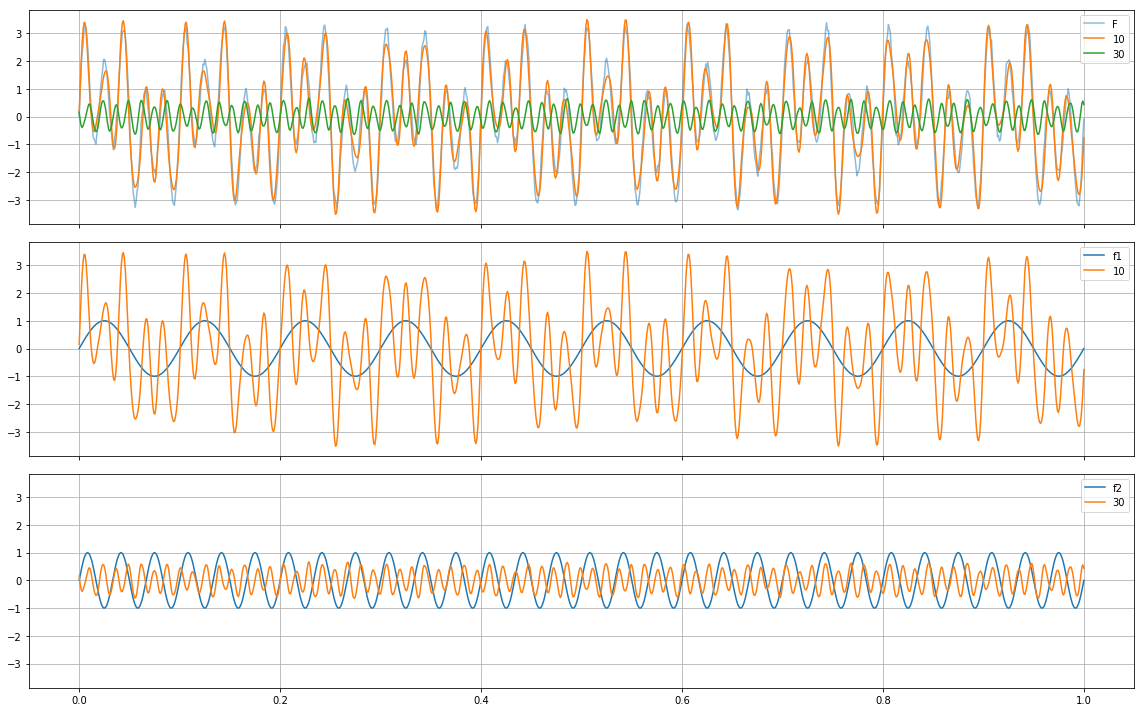

In [352]:
cA2, cD2, cD1 = pywt.wavedec(F, wvlt_db10, mode='periodization', level=2)
Fre1 = pywt.waverec((cA3, None, None, None), wvlt_db10, mode='periodization')
Fre2 = pywt.waverec((None, cD3, None, None), wvlt_db10, mode='periodization')
plot_f(F,Fre1,Fre2,f1,f2)

### Уровень 4

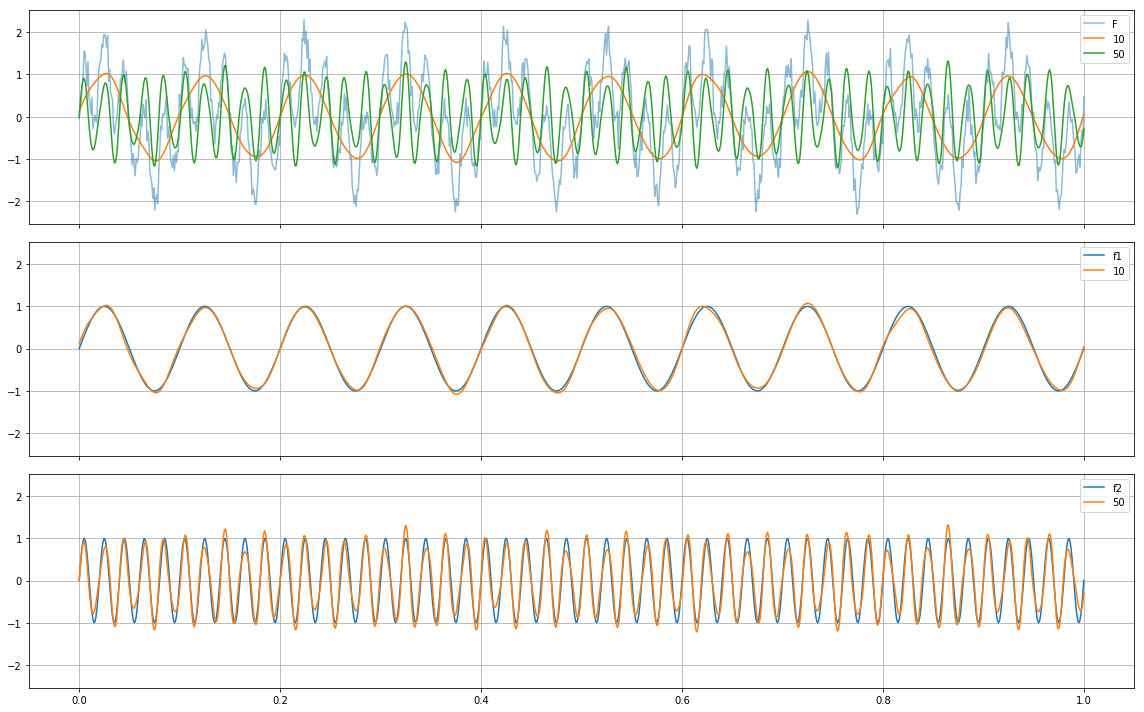

In [327]:
cA4, cD4, cD3, cD2, cD1 = pywt.wavedec(F, wvlt_db10, mode='periodization', level=4)
Fre1 = pywt.waverec((cA4, None, None, None, None), wvlt_db10, mode='periodization')
Fre2 = pywt.waverec((None, cD4, None, None, None), wvlt_db10, mode='periodization')
plot_f(F,Fre1,Fre2,f1,f2)

### Уровень 5

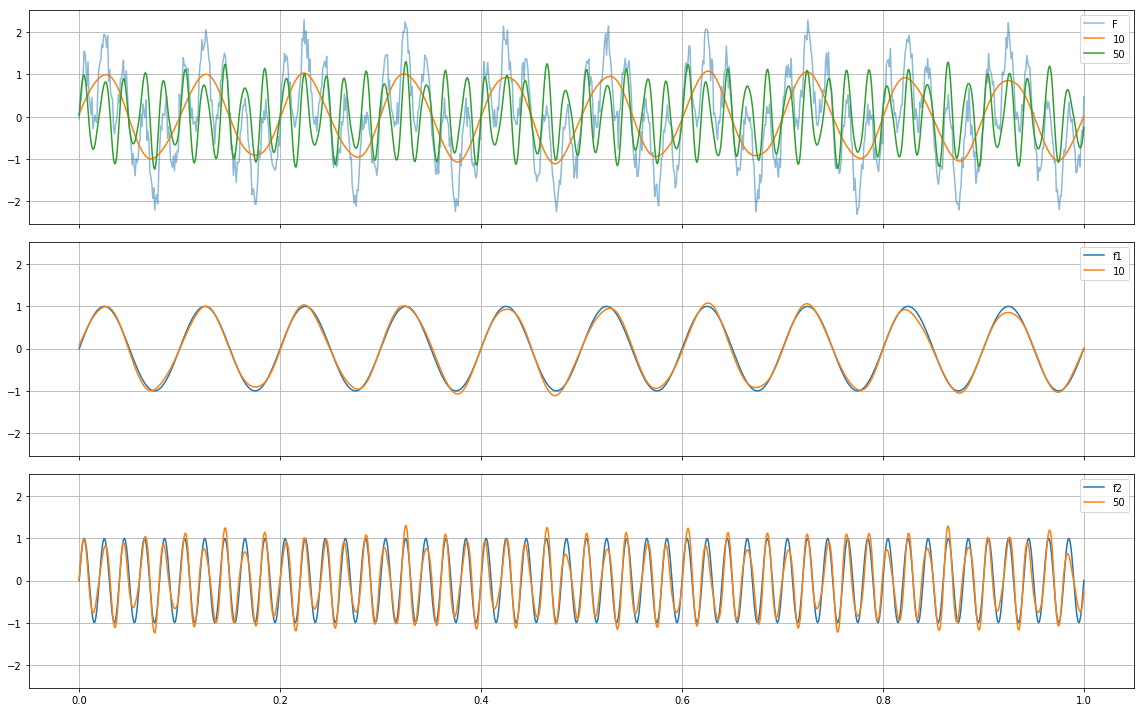

In [328]:
cA5, cD5, cD4, cD3, cD2, cD1 = pywt.wavedec(F, wvlt_db10, mode='periodization', level=5)
Fre1 = pywt.waverec((cA5, None, None, None, None, None), wvlt_db10, mode='periodization')
Fre2 = pywt.waverec((None, cD5, cD4, None, None, None), wvlt_db10, mode='periodization')
plot_f(F,Fre1,Fre2,f1,f2)

Есть и другие модификации простого вейвлет-преобразования,
позволяющие декомпозировать временные ряды. Например, есть
Стационарное Вейвлет Преобразование (Stationary Wavelet
Transform = SWT). Этот метод дает гораздо большие возможности
декомпозиции по уровню и по комбинации аппроксимаций и деталей:

In [329]:
(cA5, cD5), (cA4, cD4), (cA3, cD3), (cA2, cD2), (cA1, cD1) = pywt.swt(F, wvlt_dmey, level=5)
rr1 = pywt.iswt([(cA5, cD5)], wvlt_dmey)
rr2 = pywt.iswt([(cD4, cD3)], wvlt_dmey)

Как видно, вместо одной аппроксимации и множества деталей мы
теперь получаем пары коэффициентов аппроксимации и детали.
Причем, на самом деле, при восстановлении их можно использовать
уже в совершенно разных комбинациях. Восстановим искомые
периодические компоненты следующей комбинацией пар, при этом
нам еще потребуется нормировка, так как часть коэффициентов мы
полностью выбросили

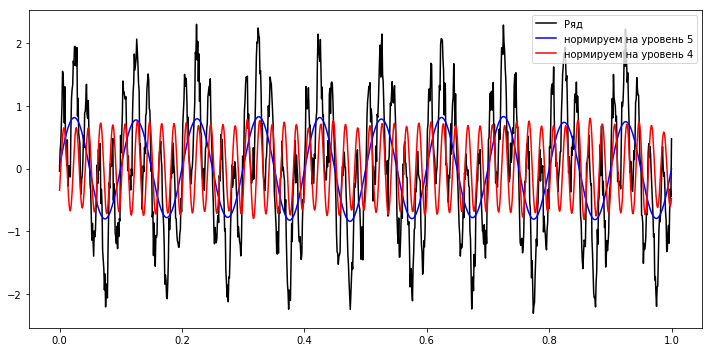

In [330]:
plt.figure(figsize = (10, 5))
plt.plot(t, F, 'k',label = 'Ряд')
plt.plot(t, rr1/5, 'b',label = 'нормируем на уровень 5') # нормируем на уровень 5
plt.plot(t, rr2/4, 'r',label = 'нормируем на уровень 4') # нормируем на уровень 4
plt.legend()
plt.tight_layout()
plt.show()

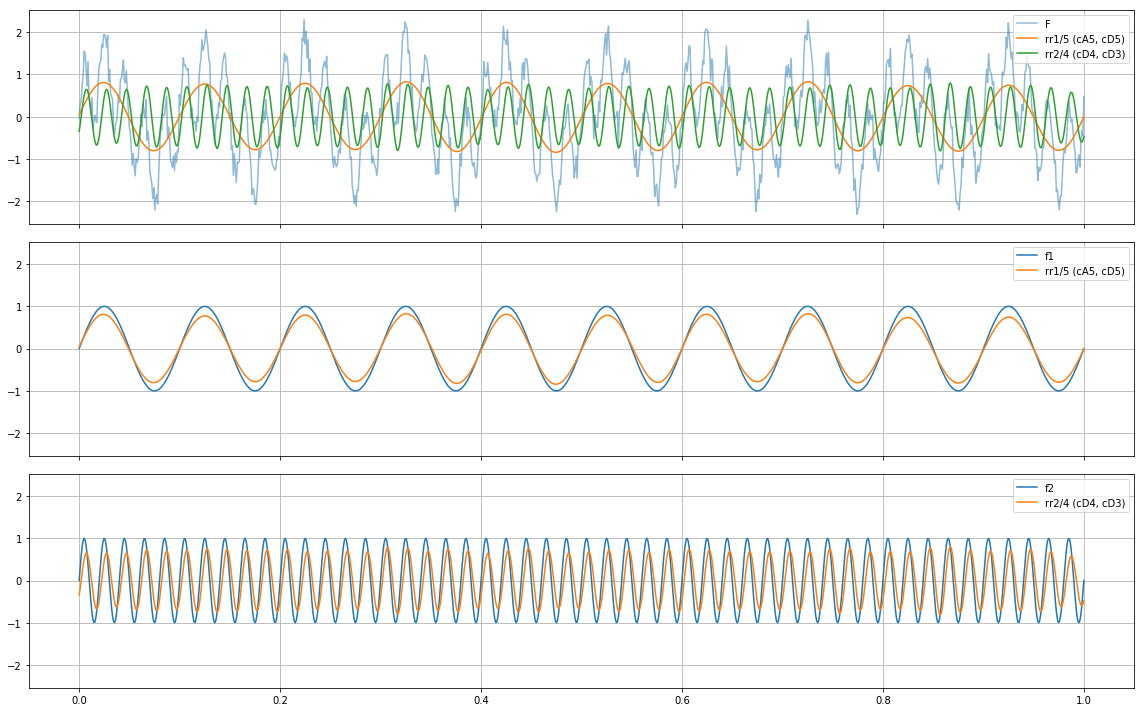

In [331]:
plot_f(F,rr1/5,rr2/4,'rr1/5 (cA5, cD5)','rr2/4 (cD4, cD3)')

Проделайте декомпозицию SWT для своего варианта вейвлета.
Уровень декомпозиции может отличаться.

## Уровень 5

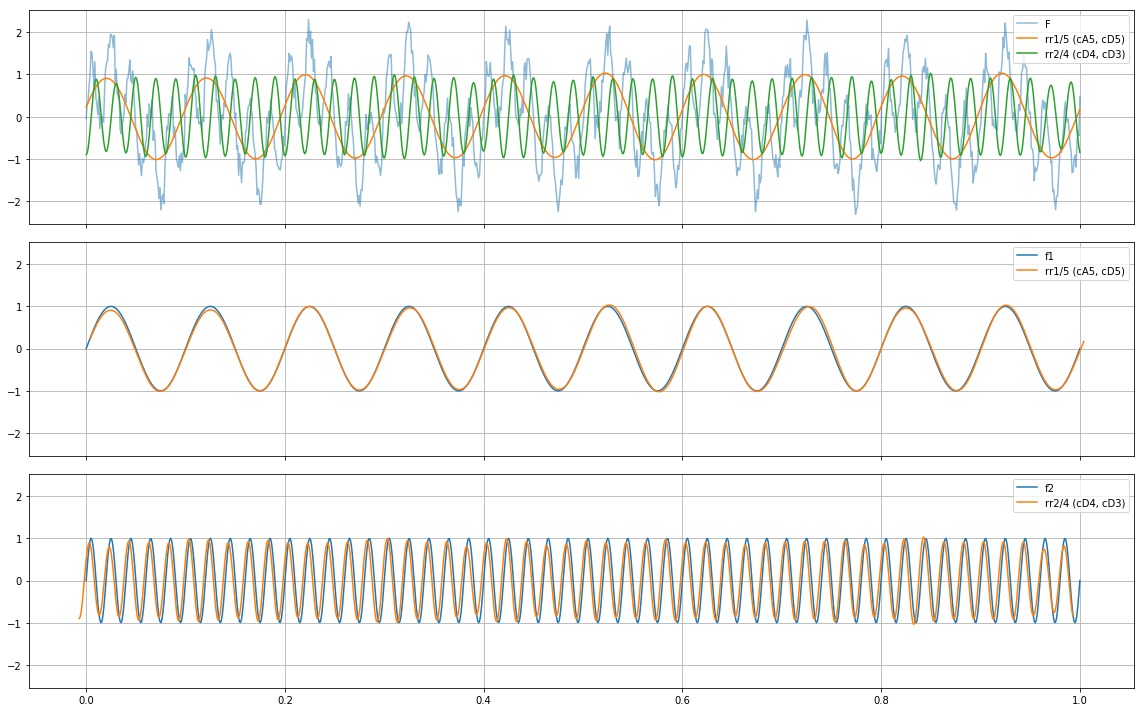

In [332]:
(cA5, cD5), (cA4, cD4), (cA3, cD3), (cA2, cD2), (cA1, cD1) = pywt.swt(F, wvlt_db10, level=5)
rr1 = pywt.iswt([(cA5, cD5)], wvlt_db10)
rr2 = pywt.iswt([(cD4, cD3)], wvlt_db10)
fig, ax = plt.subplots(3, 1, figsize=(16, 10), sharex = True, sharey=True)
ax[0].plot(t, F, alpha = 0.5, label = 'F')
ax[0].plot(t, rr1/4, label = 'rr1/5 (cA5, cD5)') # нормируем на уровень 5
ax[0].plot(t, rr2/3, label = 'rr2/4 (cD4, cD3)') # нормируем на уровень 4

ax[1].plot(t, np.sin(2*np.pi*f1*t), label = 'f1')
ax[1].plot(t+0.004, rr1/4, label = 'rr1/5 (cA5, cD5)')

ax[2].plot(t, np.sin(2*np.pi*f2*t), label = 'f2')
ax[2].plot(t-0.007, rr2/3, label = 'rr2/4 (cD4, cD3)')

polt_grid_legend(ax,3)

plt.tight_layout()
plt.show()

Ну и остался самый мощный инструмент вейвлет-декомпозиции,
называемый Пакетной Вейвлет Декомпозицией (Wavelet Packet
Decomposition = WPD). Этот метод опирается на дискретное
преобразование, но позволяет произвести полный перебор
комбинаций коэффициентов аппроксимации a и деталей d. Например,
для 4 уровня это будет 16 комбинаций вида: 'aaaa', 'aaad', 'aada', 'aadd',
'adaa', 'adad', 'adda', 'addd', 'daaa', 'daad', 'dada', 'dadd', 'ddaa', 'ddad', 'ddda', 'dddd'
Для сравнения, на 4 уровне обычной дискретной вейвлет
декомпозиции из пункта 7 доступна только одна комбинация 'addd'.

При таком большом числе возможных вариантов, декомпозиция
представляется в виде бинарного дерева, выборка или удаление узлов
из которого и будет менять после реконструкции полученные
временные ряды. Но для начала создадим общую пакетную
декомпозицию:

In [333]:
wp = pywt.WaveletPacket(data=F, wavelet='dmey', mode='periodization')
print([node.path for node in wp.get_level(4, 'freq')]) # выводим все комбинации узлов, упорядоченные по их частотной ширине спектра

['aaaa', 'aaad', 'aadd', 'aada', 'adda', 'addd', 'adad', 'adaa', 'ddaa', 'ddad', 'dddd', 'ddda', 'dada', 'dadd', 'daad', 'daaa']


Попробуем удалить один из узлов и посмотреть, что получится:

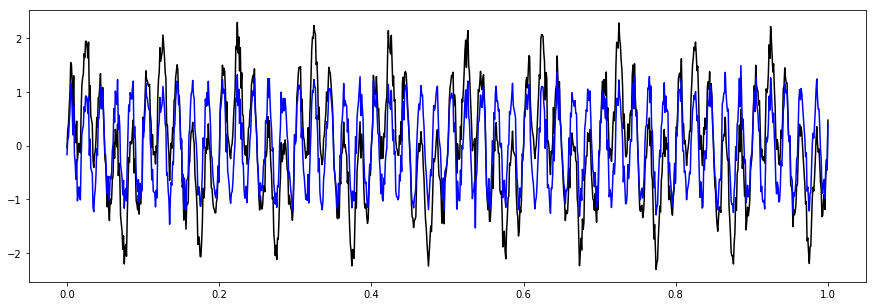

In [334]:
del wp['aaaa'] # удалим самый «глубокий» узел
reF = wp.reconstruct() # и восстановим ряд …
plt.figure(figsize = (15, 5))
plt.plot(t, F, 'k')
plt.plot(t, reF, 'b') # получим нечто периодическое, плохого качества
plt.show()

Если удаление узлов не приводит к желаемым результатам,
возможно есть смысл делать отдельную выборку ветвей этих узлов:

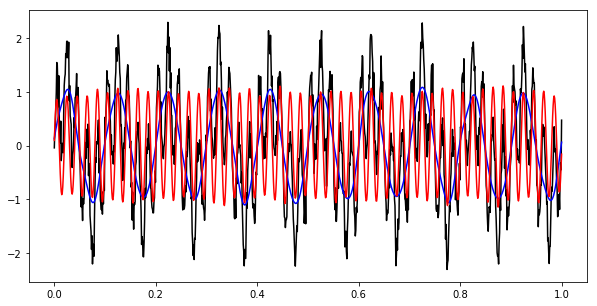

In [335]:
wp = pywt.WaveletPacket(data=F, wavelet='dmey', mode='periodization')
new_wp = pywt.WaveletPacket(data=None, wavelet='dmey', mode='periodization')
new_wp['aaaa'] = wp['aaaa'].data # выбираем первую ветвь
new_wp.reconstruct(update=True) # обновляем данные
reF1 = new_wp.data # восстанавливаем под нее ряд 1
new_wp = pywt.WaveletPacket(data=None, wavelet='dmey', mode='periodization')
new_wp['aaad'] = wp['aaad'].data # выбираем вторую ветвь
new_wp.reconstruct(update=True) # обновляем данные
reF2 = new_wp.data # восстанавливаем под нее ряд 2
plt.figure(figsize = (10, 5))
plt.plot(t, F, 'k')
plt.plot(t, reF1, 'b') # компонента 1
plt.plot(t, reF2, 'r') # компонента 2
plt.show()

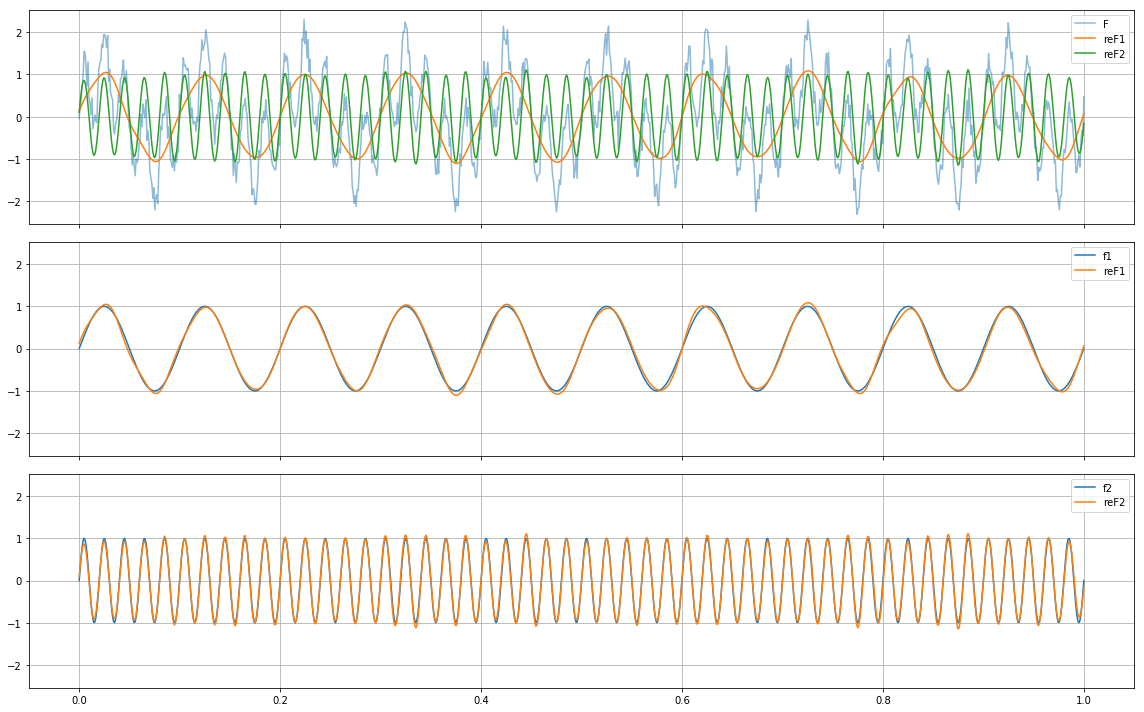

In [336]:
plot_f(F,reF1,reF2,'reF1','reF2')

In [337]:
wp = pywt.WaveletPacket(data=F, wavelet='db10', mode='periodization')
new_wp = pywt.WaveletPacket(data=None, wavelet='db10', mode='periodization')

new_wp['aaaa'] = wp['aaaa'].data # выбираем первую ветвь
new_wp.reconstruct(update=True) # обновляем данные
reF1 = new_wp.data # восстанавливаем под нее ряд 1

new_wp = pywt.WaveletPacket(data=None, wavelet='db10', mode='periodization')
new_wp['aaad'] = wp['aaad'].data # выбираем вторую ветвь
new_wp.reconstruct(update=True) # обновляем данные
reF2 = new_wp.data # восстанавливаем под нее ряд 2

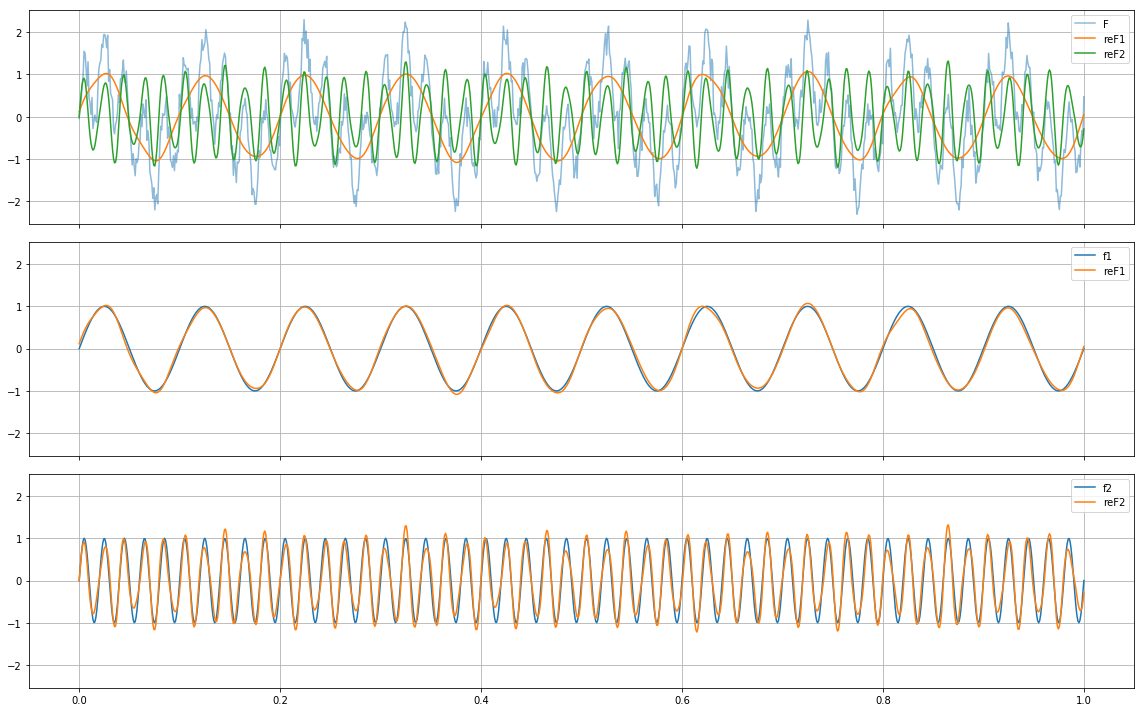

In [338]:
plot_f(F,reF1,reF2,'reF1','reF2')

Декомпозируйте сигнал с частотным изломом на 2
периодические компоненты, разделенные по времени:

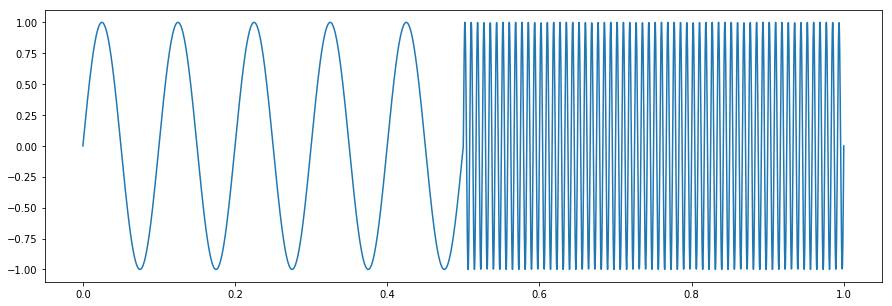

In [359]:
t = np.linspace(0, 1, 4096)
xf = np.zeros(4096)
for i in range(0, len(t)//2):
    xf[i] = np.sin(2*np.pi*10*t[i])
for i in range(len(t)//2, len(t)):
    xf[i] = np.sin(2*np.pi*120*t[i])
plt.figure(figsize = (15, 5))
plt.plot(t, xf)
plt.show()

In [366]:
wp = pywt.WaveletPacket(data=xf, wavelet='db10', mode='periodization')
new_wp = pywt.WaveletPacket(data=None, wavelet='db10', mode='periodization')

new_wp['aaaaa'] = wp['aaaaa'].data # выбираем первую ветвь
new_wp.reconstruct(update=True) # обновляем данные
reF1 = new_wp.data # восстанавливаем под нее ряд 1

new_wp = pywt.WaveletPacket(data=None, wavelet='db10', mode='periodization')
new_wp['aaadd'] = wp['aaadd'].data # выбираем вторую ветвь
new_wp.reconstruct(update=True) # обновляем данные
reF2 = new_wp.data # восстанавливаем под нее ряд 2

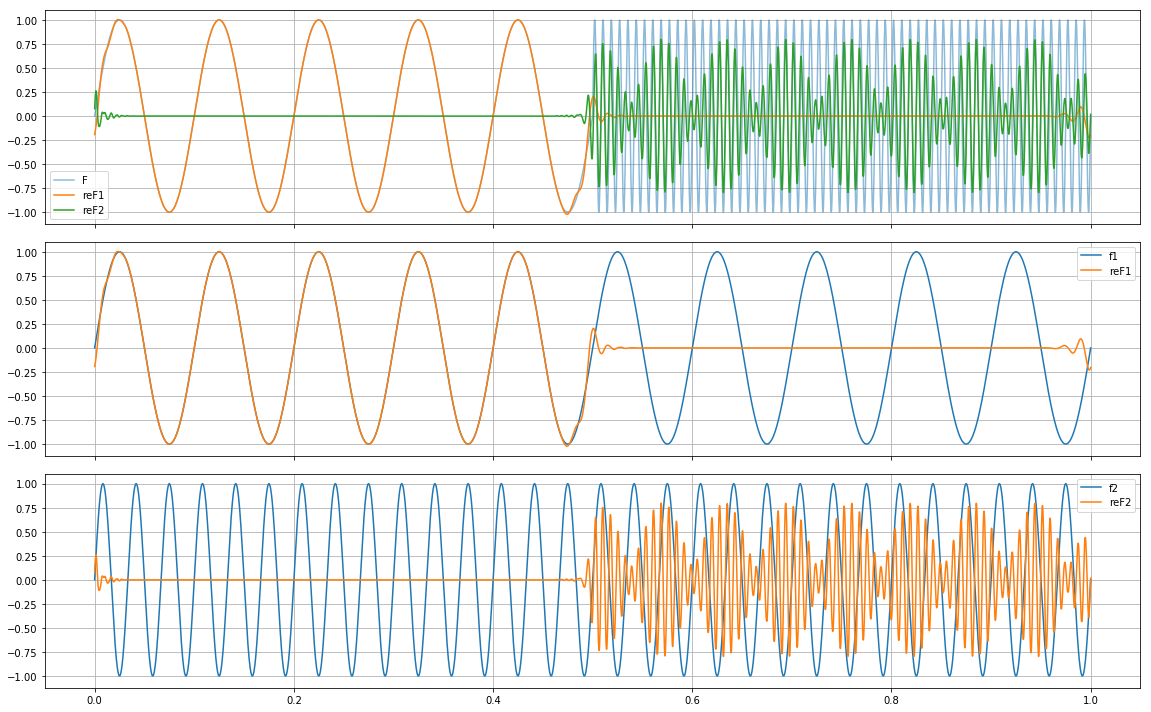

In [367]:
plot_f(xf,reF1,reF2,'reF1','reF2')

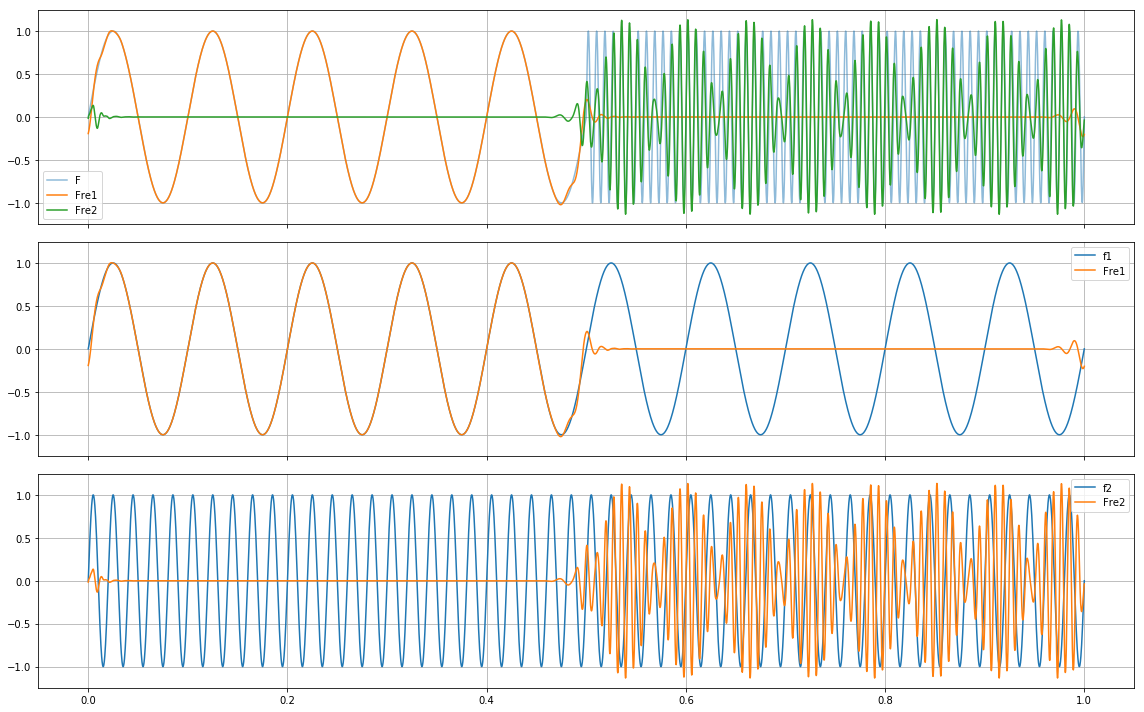

In [342]:
wvlt = pywt.Wavelet('db10')
cA5, cD5, cD4, cD3, cD2, cD1 = pywt.wavedec(xf, wvlt, mode='periodization', level=5)
Fre1 = pywt.waverec((cA5, None, None, None, None, None), wvlt, mode='periodization')
Fre2 = pywt.waverec((None, cD5, None, None, None, None), wvlt, mode='periodization')
plot_f(xf,Fre1,Fre2,'Fre1','Fre2')

Попробуйте выделить экспоненциальный тренд из следующего
зашумленного временного ряда:

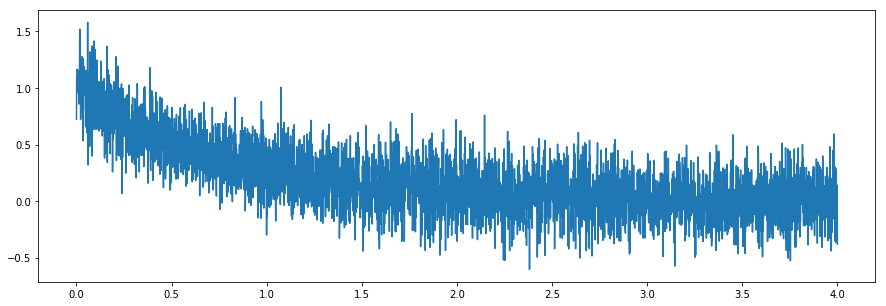

In [343]:
t = np.linspace(0, 4, 4096)
Fexp = np.exp(-0.4*np.pi*t) + 0.2*rand.randn(len(t))
plt.figure(figsize = (15, 5))
plt.plot(t, Fexp)
plt.show()

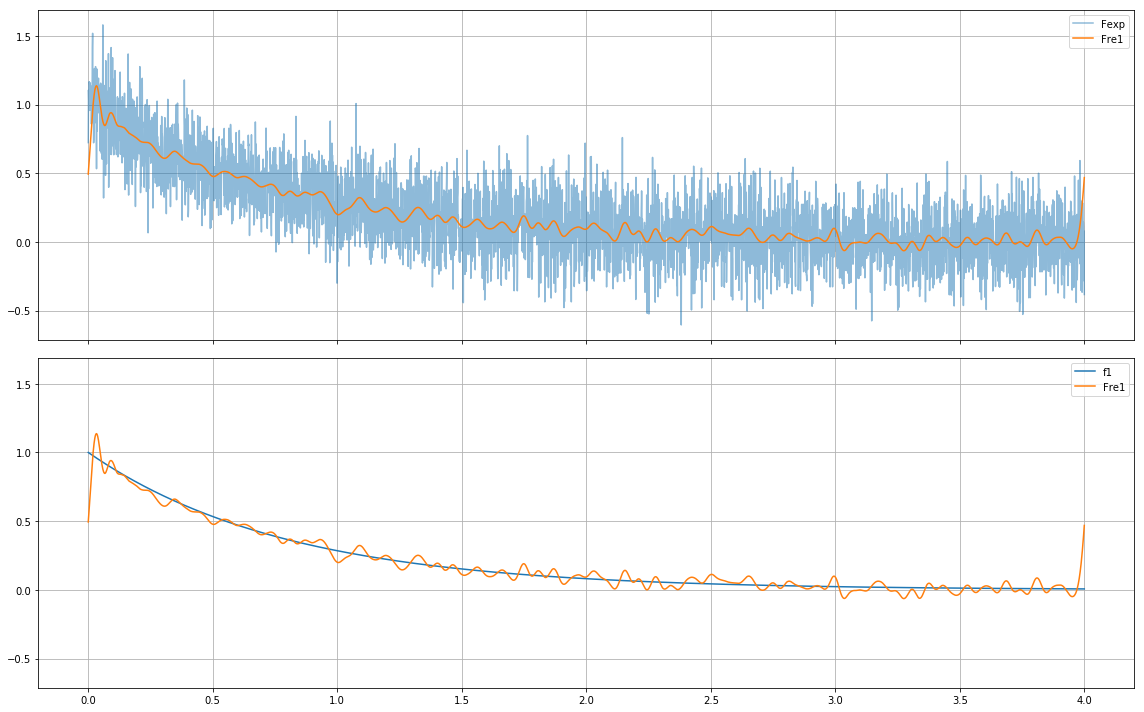

In [344]:
wvlt = pywt.Wavelet('db10')
cA5, cD5, cD4, cD3, cD2, cD1 = pywt.wavedec(Fexp, wvlt, mode='periodization', level=5)
Fre1 = pywt.waverec((cA5, None, None, None, None, None), wvlt, mode='periodization')

fig, ax = plt.subplots(2, 1, figsize=(16, 10), sharex = True, sharey=True)
ax[0].plot(t, Fexp, alpha = 0.5, label = 'Fexp')
ax[0].plot(t, Fre1, label = 'Fre1')

ax[1].plot(t, np.exp(-0.4*np.pi*t), label = 'f1')
ax[1].plot(t, Fre1, label = 'Fre1')

ax[0].grid()
ax[1].grid()

ax[0].legend()
ax[1].legend()

plt.tight_layout()
plt.show()

Самостоятельно смоделируйте ВР из 4 гармоник с шумом, и
разделите его на компоненты с помощью вейвлет декомпозиции:

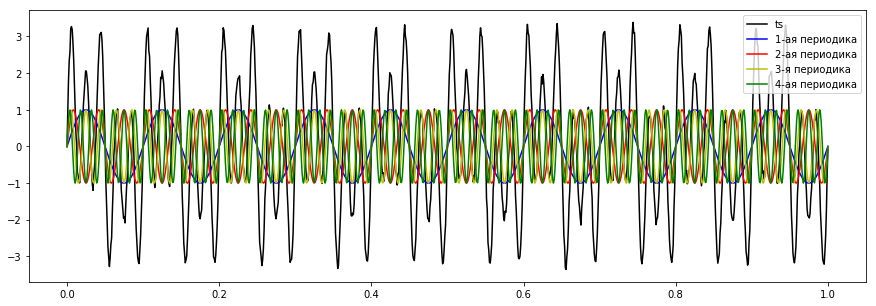

In [345]:
t = np.linspace(0, 1, 1024)
f1 = 10 
f2 = 30
f3 = 50
f4 = 70
F = np.sin(2*np.pi*f1*t) + np.sin(2*np.pi*f2*t) \
    + np.sin(2*np.pi*f3*t) + np.sin(2*np.pi*f3*t) + 0.1*rand.randn(len(t))

p1 = np.sin(2*np.pi*f1*t)
p2 = np.sin(2*np.pi*f2*t)
p3 = np.sin(2*np.pi*f3*t)
p4 = np.sin(2*np.pi*f4*t)

plt.figure(figsize = (15, 5))
plt.plot(t, F, 'k', label = 'ts')
plt.plot(t, np.sin(2*np.pi*f1*t), 'b', label = '1-ая периодика')
plt.plot(t, np.sin(2*np.pi*f2*t), 'r', label = '2-ая периодика')
plt.plot(t, np.sin(2*np.pi*f3*t), 'y', label = '3-я периодика')
plt.plot(t, np.sin(2*np.pi*f4*t), 'g', label = '4-ая периодика')
plt.legend()
plt.show()

In [346]:
(cA5, cD5), (cA4, cD4), (cA3, cD3), (cA2, cD2), (cA1, cD1) = pywt.swt(F, wvlt_db10, level=5)

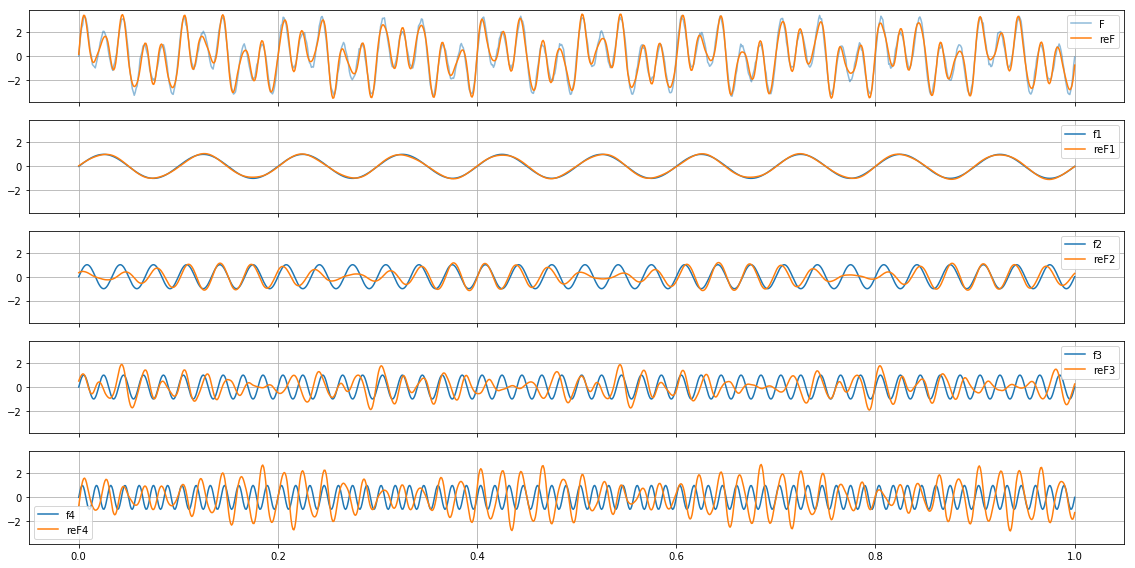

In [375]:
wp = pywt.WaveletPacket(data=F, wavelet='db10', mode='periodization')
new_wp = pywt.WaveletPacket(data=None, wavelet='db10', mode='periodization')

new_wp['aaaaa'] = wp['aaaaa'].data 
new_wp.reconstruct(update=True) 
reF1 = new_wp.data 

new_wp = pywt.WaveletPacket(data=None, wavelet='db10', mode='periodization')
new_wp['aaaad'] = wp['aaaad'].data 
new_wp.reconstruct(update=True) 
reF2 = new_wp.data

new_wp = pywt.WaveletPacket(data=None, wavelet='db10', mode='periodization')
new_wp['aaadd'] = wp['aaadd'].data 
new_wp.reconstruct(update=True)
reF3 = new_wp.data 

new_wp = pywt.WaveletPacket(data=None, wavelet='db10', mode='periodization')
new_wp['aaada'] = wp['aaada'].data 
new_wp.reconstruct(update=True)
reF4 = new_wp.data 

fig, ax = plt.subplots(5, 1, figsize=(16, 8), sharex = True, sharey=True)
ax[0].plot(t, F, alpha = 0.5, label = 'F')
ax[0].plot(t, reF1+reF2+reF3+reF4, label = 'reF') 

ax[1].plot(t, np.sin(2*np.pi*f1*t), label = 'f1')
ax[1].plot(t, reF1, label = 'reF1')

ax[2].plot(t, np.sin(2*np.pi*f2*t), label = 'f2')
ax[2].plot(t, reF2, label = 'reF2')

ax[3].plot(t, np.sin(2*np.pi*f3*t), label = 'f3')
ax[3].plot(t, reF3, label = 'reF3')

ax[4].plot(t, np.sin(2*np.pi*f4*t), label = 'f4')
ax[4].plot(t, reF4, label = 'reF4')

polt_grid_legend(ax,5)

plt.tight_layout()
plt.show()

Загрузите временной ряд из файла doppler.mat:

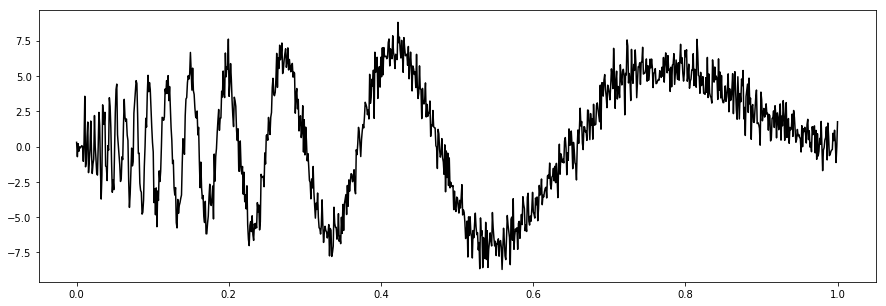

In [376]:
file = h5py.File('doppler.mat','r')
data = file.get('data')
data = np.array(data)
data = data.reshape(1024)
t = np.linspace(0, 1, 1024)
plt.figure(figsize = (15, 5))
plt.plot(t, data, 'k')
plt.show()

In [377]:
(cA5, cD5), (cA4, cD4), (cA3, cD3), (cA2, cD2), (cA1, cD1) = pywt.swt(data, wvlt_db10, level = 5)

In [386]:
wp = pywt.WaveletPacket(data=data, wavelet='db10', mode='periodization')
new_wp['aaaaa'] = wp['aaaaa'].data 
new_wp.reconstruct(update=True) 
reF1 = new_wp.data 

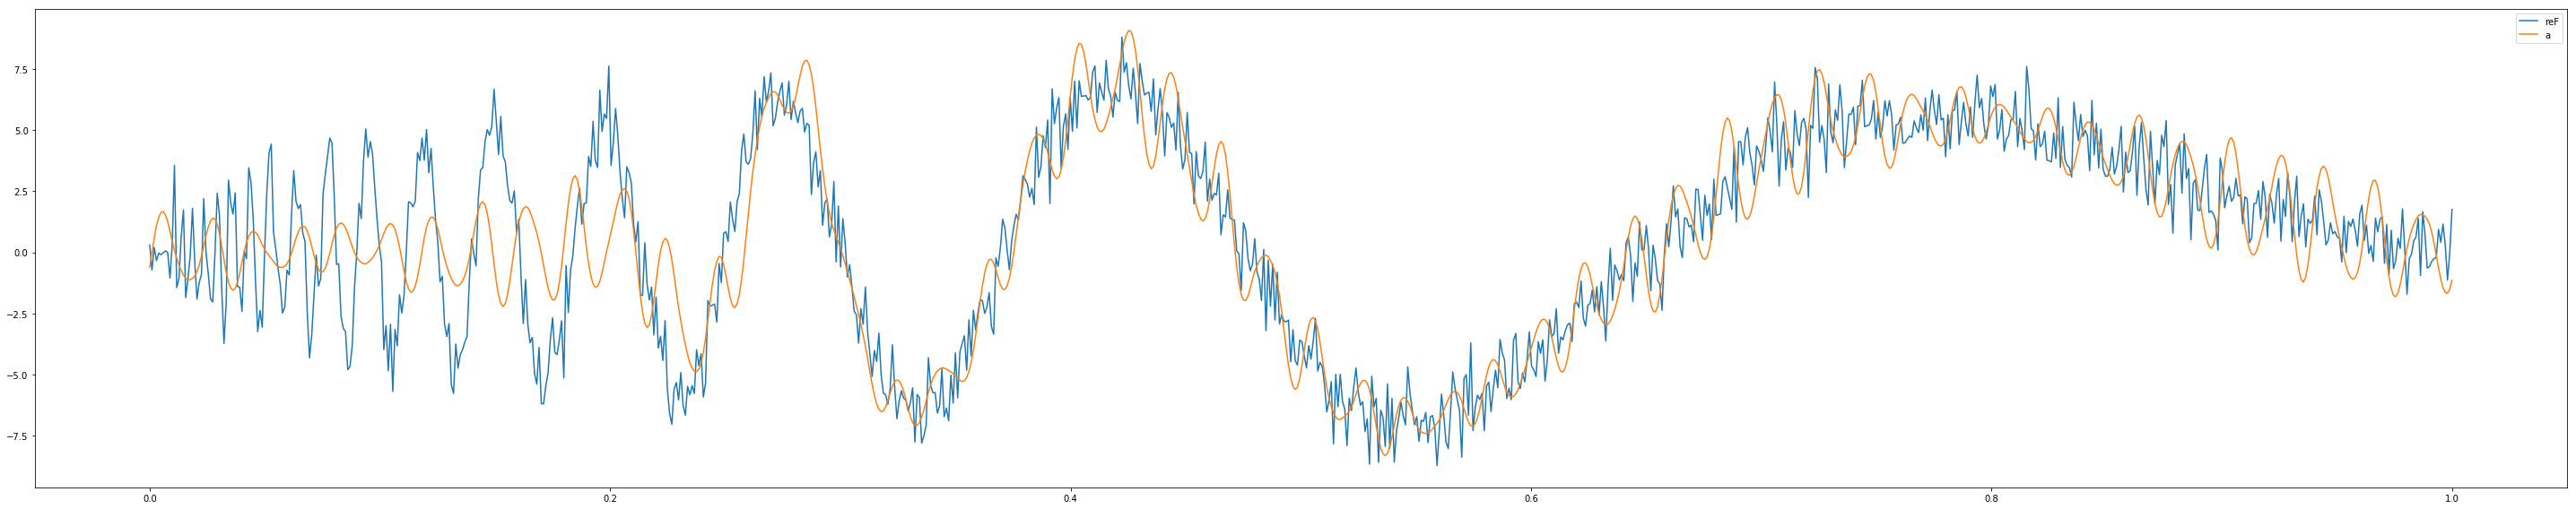

In [388]:
plt.figure(figsize=(40, 8))
plt.plot(t, data, label = 'reF')
plt.plot(t, reF1, label = 'a')
plt.tight_layout()
plt.legend()
plt.show()

In [389]:
cA4, cD4, cD3, cD2, cD1 = pywt.wavedec(data, wvlt_db10, mode='periodization', level=4)

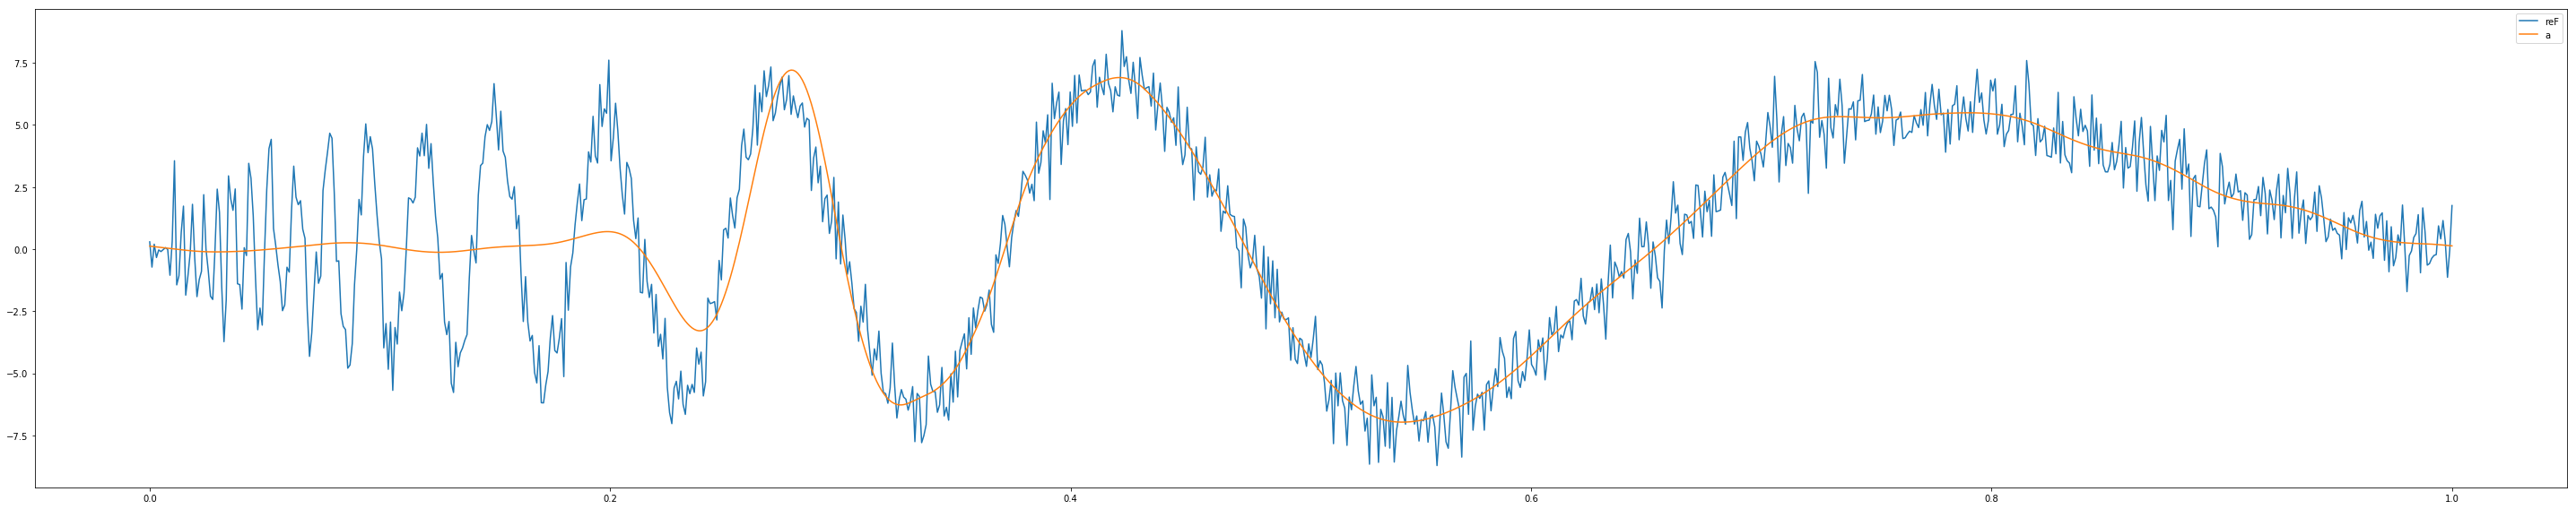

In [396]:
cA5, cD5, cD4, cD3, cD2, cD1 = pywt.wavedec(data, wvlt_db10, mode='periodization', level=5)
Fre1 = pywt.waverec((cA5, None, None, None, None, None), wvlt_db10, mode='periodization')
Fre2 = pywt.waverec((None, cD5, None, None, None, None), wvlt_db10, mode='periodization')
plt.figure(figsize=(40, 8))
plt.plot(t, data, label = 'reF')
plt.plot(t, Fre1, label = 'a')
plt.tight_layout()
plt.legend()
plt.show()

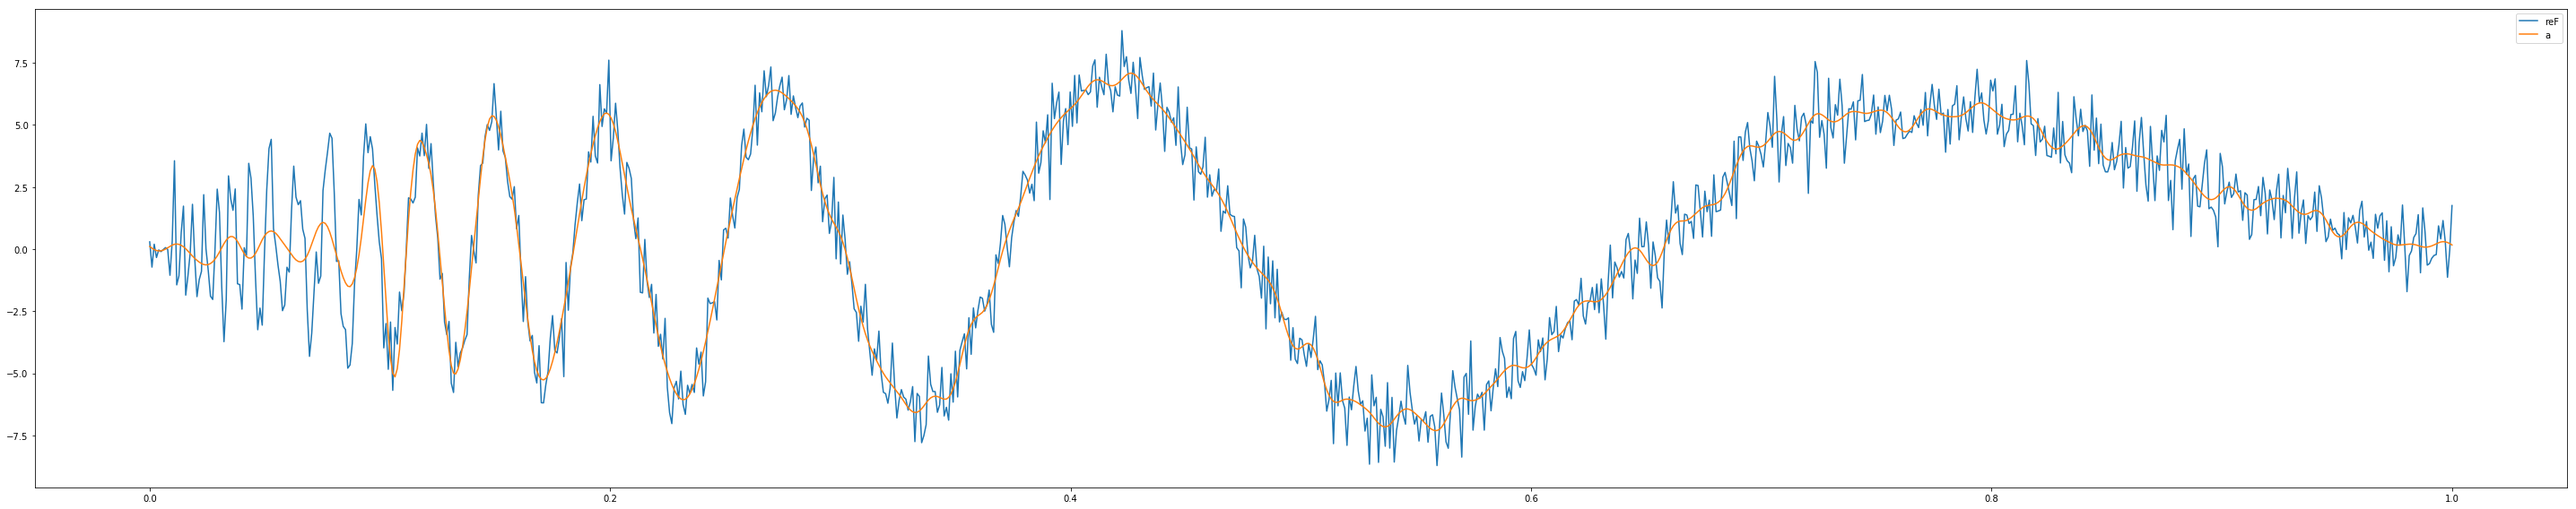

In [397]:
cA3, cD3, cD2, cD1 = pywt.wavedec(data, wvlt_db10, mode='periodization', level=3)
Fre1 = pywt.waverec((cA3, None, None, None), wvlt_db10, mode='periodization')
Fre2 = pywt.waverec((None, cD3, None, None), wvlt_db10, mode='periodization')
plt.figure(figsize=(40, 8))
plt.plot(t, data, label = 'reF')
plt.plot(t, Fre1, label = 'a')
plt.tight_layout()
plt.legend()
plt.show()

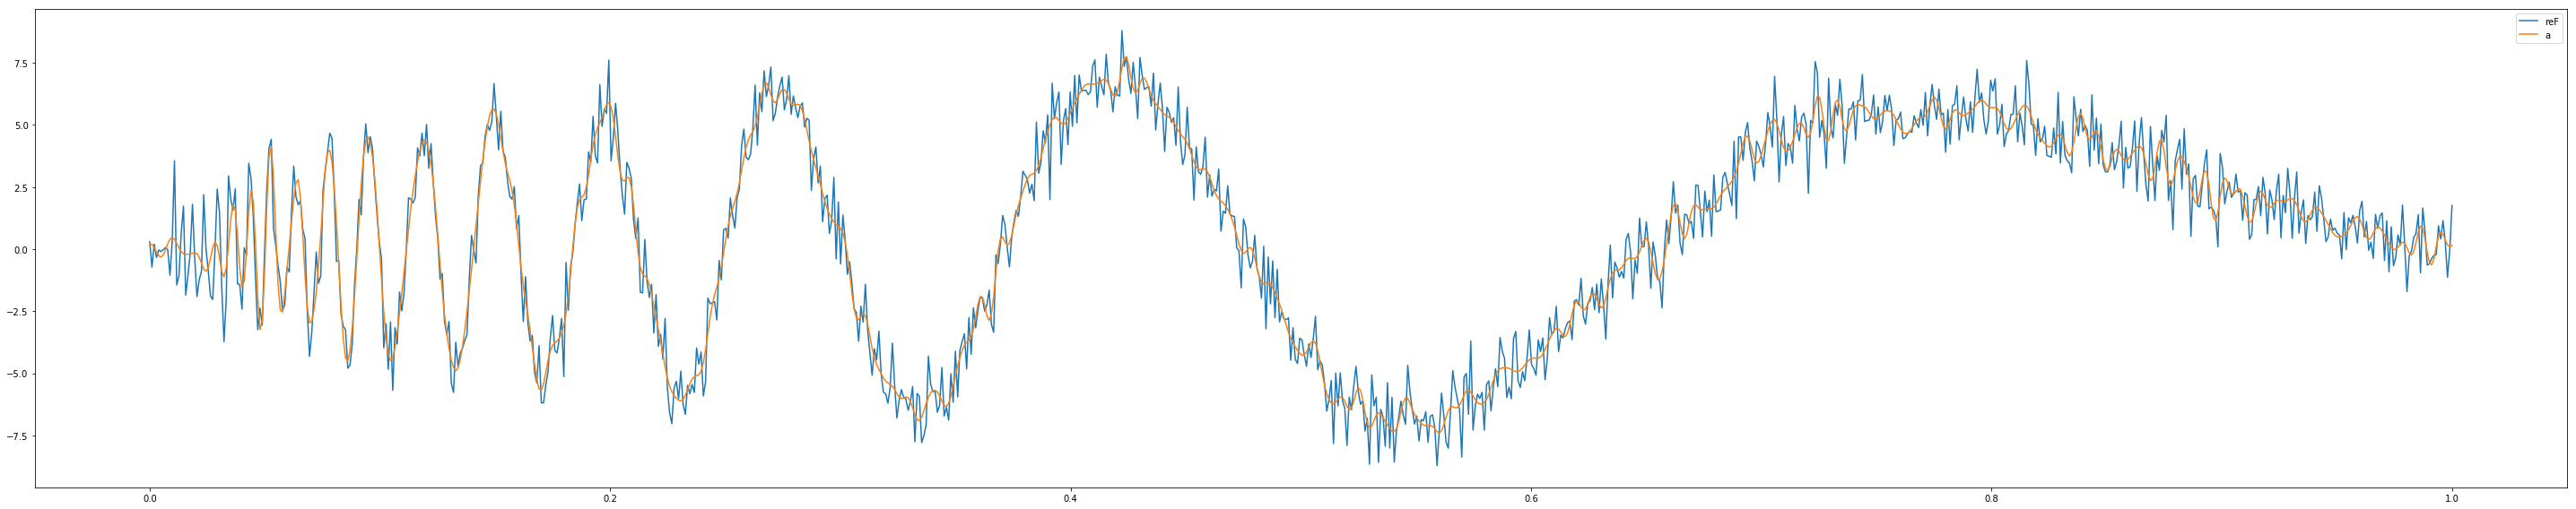

In [398]:
cA2, cD2, cD1 = pywt.wavedec(data, wvlt_db10, mode='periodization', level=2)
Fre1 = pywt.waverec((cA2, None, None), wvlt_db10, mode='periodization')
Fre2 = pywt.waverec((None, cD2, None), wvlt_db10, mode='periodization')
plt.figure(figsize=(40, 8))
plt.plot(t, data, label = 'reF')
plt.plot(t, Fre1, label = 'a')
plt.tight_layout()
plt.legend()
plt.show()